In [1]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import brainbox.io.one as bbone
import export_funs as ef

%matplotlib inline
fitdate = '2020-10-05'
fitfiles = [f'./fits/{subjdir}/{file}'
            for subjdir in os.listdir('./fits/') 
            for file in os.listdir(f'./fits/{subjdir}')
            if re.match(f'.*{fitdate}.*\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    filedata[filename] = data


Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [7]:
%qtconsole

In [3]:
from ibl_pipeline import histology


no_histology = []
observed_regions = []
for key, ses in filedata.items():
    regions = histology.ProbeTrajectory *\
        histology.ClusterBrainRegion & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                        'session_start_time': ses['sessinfo']['session_start_time'],
                                        'probe_idx': ses['sessinfo']['probe_idx']} &\
        'insertion_data_source = "Ephys aligned histology track"'
    plan_coords = histology.ProbeTrajectory & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                               'session_start_time': ses['sessinfo']['session_start_time'],
                                               'probe_idx': ses['sessinfo']['probe_idx']} &\
        'insertion_data_source = "Planned"'
    pcoordf = plan_coords.fetch(format='frame').reset_index()
    unitdf = regions.fetch(format='frame').reset_index()
    if len(unitdf) == 0:
        regions = histology.ProbeTrajectory *\
            histology.ClusterBrainRegion & {'subject_uuid': ses['sessinfo']['subject_uuid'],
                                            'session_start_time': ses['sessinfo']['session_start_time'],
                                            'probe_idx': ses['sessinfo']['probe_idx']} &\
            'insertion_data_source = "Histology track"'
        unitdf = regions.fetch(format='frame').reset_index()
        if len(unitdf) == 0:
            no_histology.append(key)
            continue
    ses['unit_regions'] = unitdf[['cluster_id', 'acronym']].set_index('cluster_id', verify_integrity=True)
    ses['coords'] = unitdf[['x', 'y', 'z']].iloc[0].values
    try:
        ses['planned_coords'] = pcoordf[['x', 'y', 'z']].iloc[0].values
    except:
        ses['planned_coords'] = np.array([0, 0, 0])
    observed_regions.extend(unitdf.acronym.unique())
_ = [filedata.pop(x) for x in no_histology]
coordset = [x['coords'] for x in filedata.values()]
allregions = list(set(observed_regions))

Connecting gercek@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek


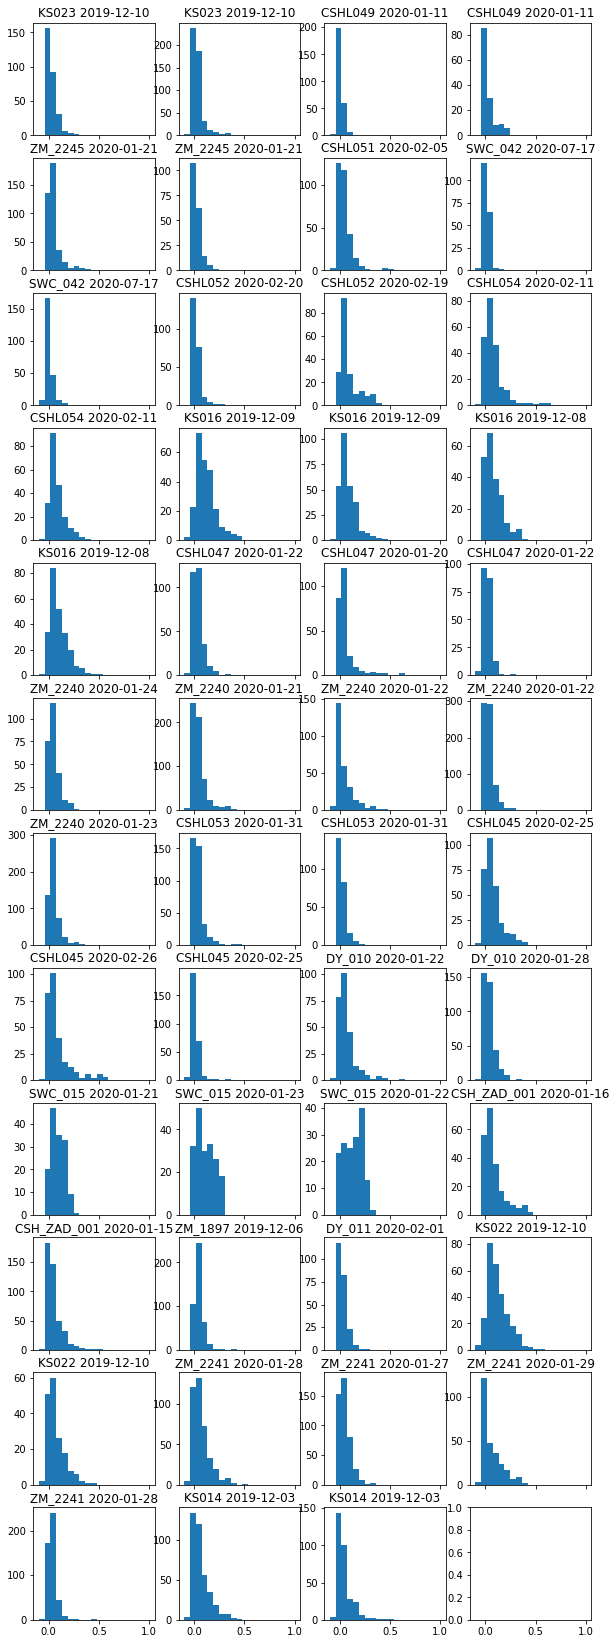

In [4]:
animals = list(set([filedata[s]['sessinfo']['subject_nickname'] for s in filedata]))

nsess = len(filedata)
fig, axes = plt.subplots(np.ceil(len(filedata) / 4).astype(int), 4, sharex=True, figsize=(10, nsess / 4 * 2.5))
axes = axes.flatten()
scorebins = np.linspace(-0.1, 1., 20)
for i, s in enumerate(filedata):
    scores = filedata[s]['fitobj'].submodel_scores
    sinfo = filedata[s]['sessinfo']
    axes[i].hist(scores['6cov'], bins=scorebins)
    axes[i].set_title(sinfo['subject_nickname'] + ' ' + str(sinfo['session_end_time'].date()))

In [23]:
from ibllib.atlas import regions_from_allen_csv
sess_strs = {s['sessinfo']['subject_nickname'] + ' from ' +
             str(s['sessinfo']['session_start_time'].date()) + ' probe: ' +
             str(s['sessinfo']['probe_idx']) : fn for fn, s in filedata.items() if fn not in no_histology}

masterscores = []
noreg_masterscores = []
for fn in filedata:
    scores = filedata[fn]['fitobj'].submodel_scores.copy()
    noreg_masterscores.append(scores.copy())
    regions = filedata[fn]['unit_regions']
    scores['acronym'] = regions['acronym']
    scores = scores[pd.notna(scores['acronym'])]
    masterscores.append(scores)
masterscores = pd.concat(masterscores)
noreg_masterscores = pd.concat(noreg_masterscores)

brainregions = regions_from_allen_csv()
def get_parent_name(brainregion):
    regid = brainregions.id[np.argwhere(brainregions.acronym == brainregion)]
    ancestors = brainregions.ancestors(regid)
    targetlevel = 6
    if sum(ancestors.level == targetlevel) == 0:
        return ancestors.name[-1]
    return ancestors.name[np.argwhere(ancestors.level == targetlevel)[0, 0]]

masterscores['parent_name'] = masterscores['acronym'].apply(get_parent_name)
# masterscores['1covmax'] = masterscores.loc[:, 'correct':'wheel'].idxmax(axis=1)
masterscores.reset_index(inplace=True)
def sort_df(df):
    return pd.DataFrame(
        data=df.columns.values[np.argsort(-df.values, axis=1)],
        columns=['tag_{}'.format(i) for i in range(df.shape[1])])
sortcovs = sort_df(masterscores.loc[:, 'correct':'wheel'])
masterscores = pd.concat([masterscores, sortcovs], axis=1)

In [44]:
min_cells = 20
regcounts = pd.value_counts(masterscores['parent_name'])
high_count_regs = regcounts[regcounts > min_cells].index
covars = masterscores.loc[:, 'correct':'wheel'].columns

@interact
def plot_region_summary(reg=high_count_regs):
    plt.close('all')
    regiondf = masterscores[masterscores.parent_name == reg]
    singlepar_max = regiondf.loc[:, 'correct':'wheel'].idxmax(axis=1)
    singlepar_maxcounts = singlepar_max.value_counts()
    singlepar_maxcounts.plot(kind='bar', figsize=(8, 3))
    top3 = singlepar_maxcounts.index[:3]
    topdf = regiondf[top3]
    plt.figure(figsize=(10, 4))
    sns.histplot(data=topdf)
    ax = plt.gca()
    ax.set_xlim([-0.05, 0.1])
    for bestcov in singlepar_maxcounts.index:
        plt.figure()
        subsetdf = regiondf[regiondf['tag_0'] == bestcov]
        sns.jointplot(x=bestcov, y=subsetdf['2cov'] - subsetdf[bestcov], hue='tag_1',
                          data=subsetdf)
    return

interactive(children=(Dropdown(description='reg', options=('Hippocampal region', 'Lateral group of the dorsal …

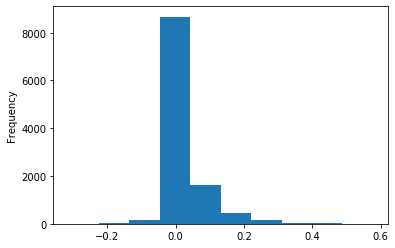

In [250]:
(masterscores['correct'] - masterscores.loc[:, 'incorrect':'wheel'].max(axis=1)).plot(kind='hist')


In [6]:
from ipywidgets import interact, Dropdown
from brainbox.plot import peri_event_time_histogram

sess_str = Dropdown(options=sess_strs.keys())
unitsel = Dropdown()

coordset = np.array(coordset)

@interact(session=sess_str, unit=unitsel)
def plot_units(session, unit):
    sessdict = filedata[sess_strs[session]]
    sessdate = str(sessdict['sessinfo']['session_start_time'].date())
    trialsdf = sessdict['trialsdf']
    print('Unit counts per region recorded:')
    sessdict['unit_regions'].groupby(['acronym'], sort=False).count()
    unitsel.options = list(sessdict['fitobj'].clu_ids)
    unit_reg = sessdict['unit_regions'].loc[unit[0]].acronym
    print(f'Unit {unit} from region {unit_reg}')
    print('D^2 of ', sessdict['scores'].loc[unit[0]])
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    peri_event_time_histogram(sessdict['spk_t'], sessdict['spk_clu'], trialsdf.stimOn_times[np.isfinite(trialsdf.contrastLeft) & (trialsdf.contrastLeft > 0)],
                              unit[0], t_before=0, t_after=0.6, ax=axes[0, 0], error_bars='sem')
    axes[0, 0].set_title('Stim on Left PETH')
    peri_event_time_histogram(sessdict['spk_t'], sessdict['spk_clu'], trialsdf.stimOn_times[np.isfinite(trialsdf.contrastRight) & (trialsdf.contrastRight > 0)],
                              unit[0], t_before=0, t_after=0.6, ax=axes[0, 1], error_bars='sem')
    axes[0, 1].set_title('Stim on Right PETH')
    axes[1, 0].plot((1 / 0.02) * np.exp(0.5 * sessdict['weights']['stimonL'].loc[unit[0]] + sessdict['fitobj'].intercepts.loc[unit[0]]))
    axes[1, 0].set_title('Stim on L weights')
    axes[1, 1].plot((1 / 0.02) * np.exp(0.5 * sessdict['weights']['stimonR'].loc[unit[0]] + sessdict['fitobj'].intercepts.loc[unit[0]]))
    axes[1, 1].set_title('Stim on R weights')
    peri_event_time_histogram(sessdict['spk_t'], sessdict['spk_clu'], trialsdf.feedback_times[trialsdf.feedbackType == 1],
                              unit[0], t_before=0, t_after=0.6, ax=axes[2, 0], error_bars='sem')
    axes[2, 0].set_title('Correct feedback PETH')
    peri_event_time_histogram(sessdict['spk_t'], sessdict['spk_clu'], trialsdf.feedback_times[trialsdf.feedbackType == -1],
                              unit[0], t_before=0, t_after=0.6, ax=axes[2, 1], error_bars='sem')
    axes[2, 1].set_title('Correct feedback PETH')
    axes[3, 0].plot((1 / 0.02) * np.exp(sessdict['weights']['correct'].loc[unit[0]] + sessdict['fitobj'].intercepts.loc[unit[0]]))
    axes[3, 0].set_title('Correct feedback weights')
    axes[3, 1].plot((1 / 0.02) * np.exp(sessdict['weights']['incorrect'].loc[unit[0]] + sessdict['fitobj'].intercepts.loc[unit[0]]))
    axes[3, 1].set_title('Incorrect feedback weights')
    plt.tight_layout()

    

interactive(children=(Dropdown(description='session', options=('KS023 from 2019-12-10 probe: 0', 'KS023 from 2…

In [5]:
from ibl_pipeline.analyses import behavior
from ibl_pipeline import subject
from ibl_pipeline.utils import psychofit as psy
from datetime import timedelta

xx = np.linspace(-100, 100, 100)
psychometric = behavior.PsychResultsBlock * subject.Subject
for filename in filedata:
    sinf = filedata[filename]['sessinfo']
    sesspsy = psychometric & 'subject_nickname = "{}"'.format(sinf['subject_nickname']) &\
        'session_start_time = "{}"'.format(sinf['session_start_time'])
    sessdf = sesspsy.fetch(format='frame').reset_index()
    low, med, high = sessdf[sessdf.prob_left_block == 20], sessdf[sessdf.prob_left_block == 50], sessdf[sessdf.prob_left_block == 80]
    left_low = psy.erf_psycho_2gammas(np.array([low.iloc[0].bias,
                                                low.iloc[0].threshold,
                                                low.iloc[0].lapse_low,
                                                low.iloc[0].lapse_high]), xx)
    left_med = psy.erf_psycho_2gammas(np.array([med.iloc[0].bias,
                                                med.iloc[0].threshold,
                                                med.iloc[0].lapse_low,
                                                med.iloc[0].lapse_high]), xx)
    left_high = psy.erf_psycho_2gammas(np.array([high.iloc[0].bias,
                                                 high.iloc[0].threshold,
                                                 high.iloc[0].lapse_low,
                                                 high.iloc[0].lapse_high]), xx)
    filedata[filename]['psyfuncs'] = (left_low, left_med, left_high)
    filedata[filename]['psychdata'] = sessdf[['prob_left_block', 'signed_contrasts', 'prob_choose_right']].set_index('prob_left_block')

Connecting gercek@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [6]:
# fig, ax = plt.subplots(len(scoredf), 2, figsize=(10, len(scoredf) * 2.5))
# for i, (filename, fitdata) in enumerate(filedata.items()):
#     trialsdf = fitdata['fitobj'].trialsdf
#     psychdata = fitdata['psychdata']
#     corrval = np.corrcoef(trialsdf.bias - trialsdf.bias.mean(), trialsdf.probabilityLeft)[0, 1]**2
#     perc_corr = np.sum(trialsdf.feedbackType == 1) / len(trialsdf)
#     meansub = trialsdf.bias - trialsdf.bias.mean()
#     shift_rescale = (meansub - meansub.min()) / (meansub - meansub.min()).max()
#     ax[i, 0].plot(shift_rescale, label='Psytrack estimate')
#     ax[i, 0].plot(trialsdf.probabilityLeft, label='P(Left)')
#     ax[i, 0].set_title(f'$R^2$ of {corrval:0.2f}, {perc_corr * 100:0.02f}% correct')
#     ax[i, 1].scatter(psychdata.loc[20].signed_contrasts * 100,
#                   psychdata.loc[20].prob_choose_right, label='P(Left) = 0.2', color='red')
#     ax[i, 1].plot(xx, fitdata['psyfuncs'][0], color='red')
#     ax[i, 1].scatter(psychdata.loc[50].signed_contrasts * 100,
#                   psychdata.loc[50].prob_choose_right, label='P(Left) = 0.5', color='black')
#     ax[i, 1].plot(xx, fitdata['psyfuncs'][1], color='black')
#     ax[i, 1].scatter(psychdata.loc[80].signed_contrasts * 100,
#                   psychdata.loc[80].prob_choose_right, label='P(Left) = 0.8', color='blue')
#     ax[i, 1].plot(xx, fitdata['psyfuncs'][2], color='blue')
#     ax[i, 1].set_ylabel('P(Right choice)')
#     if i % 3 == 0:
#         ax[i, 1].legend()


    
# plt.tight_layout()

In [96]:
missing_units = {fn : [] for fn in filedata}

for key, ses in filedata.items():
    scores = ses['fitobj'].score()
    ses['scores'] = scores
    weights = (scores - scores.min()) / (scores - scores.min()).sum()
    abspgain = scores.apply(np.abs)
    sesmeangain = (abspgain * weights).sum()
    ses['mean_modulation'] = sesmeangain

    regscores = pd.DataFrame(abspgain, columns=['scores'])
    regscores['acronym'] = 'none'
    regscores['weights'] = scores - scores.min()
    for cell in scores.index:
        try:
            cellreg = ses['unit_regions'].acronym.loc[cell]
            regscores.loc[cell, 'acronym'] = cellreg
        except:
            missing_units[key].append(cell)
            regscores.drop(cell)
            continue
    regsums = regscores.groupby('acronym').sum()['weights']
    regscores['regweight'] = regscores.apply(lambda s: s.weights / regsums.loc[s.acronym], axis=1)
    wmeanregscores = regscores.groupby('acronym').apply(lambda df: (df.scores * df.regweight).sum())
    ses['region_wmean_abs_scores'] = wmeanregscores


In [ ]:
from oneibl import one
from export_funs import trialinfo_to_df
one = one.ONE()

for fn in filedata:
    data = filedata[fn]
    s = data['sessinfo']
    sessdate = str(s['session_start_time'].date())
    ids = one.search(subject=s['subject_nickname'], date_range=[sessdate, sessdate])
    data['spk_t'] = one.load(ids[0], 'spikes.times', offline=True)[s['probe_idx']]
    data['spk_clu'] = one.load(ids[0], 'spikes.clusters', offline=True)[s['probe_idx']]
    data['trialsdf'] = trialinfo_to_df(ids[0], maxlen=2.)
    

In [ ]:
nunit_criterion = 60
high_count_regs = [region for region in tot_units if tot_units[region] > nunit_criterion]
region_props = [{'region': reg, 'n_units': tot_units[reg],
                 **{key : sig_count[reg][key] / tot_units[reg] for key in sig_count[reg] if key != 'scores'}}
                for reg in high_count_regs]
proportiondf = pd.DataFrame(region_props)
proportiondf['difference'] = proportiondf.stimonR - proportiondf.stimonL
sortdf = proportiondf.sort_values('difference')
fig, axes = plt.subplots(1, 1, figsize=(12, 20))
sns.barplot(x='difference', y='region', data=sortdf, ax=axes)
plt.xlabel('stimonR - stimonL')

In [ ]:
fig, axes = plt.subplots(len(high_count_regs), 1, figsize=(6, len(high_count_regs) * 1.2), sharex=True)
regseries = pd.DataFrame([{'region': reg, 'mean': np.median(sig_count[reg]['scores'])}
                          for reg in high_count_regs]).set_index('region').sort_values('mean', ascending=False)
for i, reg in enumerate(regseries.index):
    sns.distplot(sig_count[reg]['scores'], kde=False, rug=True, ax=axes[i])
    axes[i].set_ylabel(reg)
axes[-1].set_xlim([-0.05, 0.7])

In [97]:
sigdf = pd.DataFrame([{'x': s['coords'][0],
                       'y': s['coords'][1],
                       'z': s['coords'][2],
                       'score_mean': s['scores'].mean(),
                       'wmean_absgain': s['mean_modulation'],
                       'wmean_region_absgain': s['region_wmean_abs_scores'],
                       'regions': '\n'.join(f'{reg} {count}'
                                            for reg, count in pd.value_counts(s['unit_regions'].acronym, sort=False).iteritems())}
                      for s in filedata.values()])

In [99]:
import plotly.express as px

fig = px.scatter(sigdf, 'x', 'y', color='wmean_absgain',
                 labels={'x': 'Medial-Lateral (micrometers)',
                         'y': 'Anterior-Posterior (micrometers)',
                         'score_mean': 'Mean D^2 of GLM'},
                 size='wmean_absgain', hover_name='regions', title='Overall fit scores median')
fig.show()
fig.write_html('/home/berk/Documents/GLMscores_bypenetration_stimfdbkwheel.html')

# @interact
# def plot_significance(kernel=['stimonL', 'stimonR', 'correct', 'incorrect', 'wheel']):
#     fig = plt.figure(figsize=(10, 10))
#     cmap = np.array(sns.cubehelix_palette(50, start=.5, rot=-.75))
#     cbins = np.linspace(0, 1, 50)
#     cbinned = np.digitize(sigdf[kernel], cbins)
#     cbinned[cbinned > 99] = 99
#     fig = px.scatter(sigdf, 'x', 'y', color=kernel, size=kernel, hover_name='regions', title=kernel)
#     fig.show()

In [129]:
region_means = {}
for ses in filedata.values():
    regcellcounts = pd.value_counts(ses['unit_regions']['acronym'])
    for region in ses['region_wmean_abs_scores'].index:
        if region not in region_means and region != 'none':
            region_means[region] = []
        if region != 'none':
            region_means[region].append((regcellcounts[region], ses['region_wmean_abs_scores'][region]))

wregmeans = {}
for region in region_means:
    regarr = np.array(region_means[region])
    weights = regarr[:, 0] / np.sum(regarr[:, 0])
    wmean = np.sum(regarr[:, 1] * weights)
    wregmeans[region] = wmean

In [130]:
wregmeans

{'CA1': 0.060401628299430965,
 'DG-mo': 0.057651342936679464,
 'DG-po': 0.053357559385574335,
 'DG-sg': 0.07956345756474045,
 'LP': 0.05052293825208288,
 'PO': 0.07852808818492582,
 'TH': 0.09197219357267569,
 'VISa5': 0.05770307475578208,
 'VISa6a': 0.07045620066021716,
 'VISa6b': 0.017022470642144242,
 'VPLpc': 0.04412589800256545,
 'VPM': 0.068194669320228,
 'alv': 0.07067718285388885,
 'ccs': 0.0698406388226235,
 'ml': 0.04990495422263153,
 'root': 0.06898948906776486,
 'scwm': 0.047384830245473734,
 'ACAd6a': 0.05534147240613988,
 'ACAv5': 0.042096904436076325,
 'ACAv6a': 0.03005142676775531,
 'DP': 0.04056993580767973,
 'LSr': 0.07505063421502349,
 'MOs5': 0.05126125832643558,
 'PL5': 0.05868622888863139,
 'PL6a': 0.12745730980315834,
 'STR': 0.06560178229242458,
 'TTd': 0.04491258864814639,
 'BLAp': 0.013653736073248848,
 'BMAp': 0.006456530800048366,
 'PAA': 0.01087093067612397,
 'TR': 0.038691609872464304,
 'VL': 0.022557082089066312,
 'fi': 0.05107699271053215,
 'fiber tracts

In [17]:
from oneibl import one
one=one.ONE()
sessdict = list(filedata.values())[1]
sessdate = str(sessdict['sessinfo']['session_start_time'].date())
ids = one.search(subject=sessdict['sessinfo']['subject_nickname'], date_range=[sessdate, sessdate])
spikes = one.load(ids[0], 'spikes.times', offline=True)

Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [18]:
peri_event_time_histogram?